In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# EDA и начало Feature Engineering

In [17]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

1. **Предположим, что те люди, у которых не было родственников на борту, выживали чаще, чем те, у кого они были.**

Для начала, добавим колонку, которая будет содержать информацию об общем количестве родственников на борту. Это позволит модели более точно учитывать их при обучении и, затем, при предсказании.

In [19]:
train_df['TotalRelatives'] = train_df['Parch'] + train_df['SibSp']

Теперь построим нужный график, который покажет ответ на нашу гипотезу

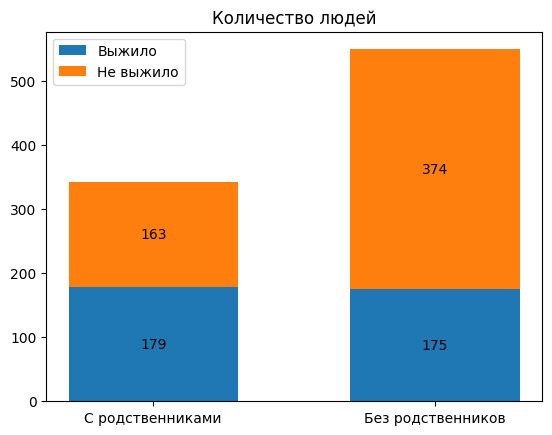

In [20]:
import matplotlib.pyplot as plt
survived_with_relatives = len(train_df[(train_df.TotalRelatives > 0) & (train_df.Survived == 1.0)])
not_survived_with_relatives = len(train_df[(train_df.TotalRelatives > 0) & (train_df.Survived == 0)])
survived_without_relatives = len(train_df[(train_df.TotalRelatives == 0) & (train_df.Survived == 1.0)])
not_survived_without_relatives = len(train_df[(train_df.TotalRelatives == 0) & (train_df.Survived == 0)])
name = ('С родственниками', 'Без родственников')
labels = {
    'Выжило': np.array([survived_with_relatives, not_survived_with_relatives]),
    'Не выжило': np.array([survived_without_relatives, not_survived_without_relatives]),
}
width = 0.6 


fig, ax = plt.subplots()
bottom = np.zeros(2)

for label, amount in labels.items():
    p = ax.bar(name, amount, width, label=label, bottom=bottom)
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.set_title('Количество людей')
ax.legend()

plt.show()


**Вывод**: Как оказалось, не смотря на то, что количество выживших людей с родственниками и без примерно одинаково, именно люди, у которых были родственнии, выживали чаще. Хотя общее количество людей без родственников, конечно, больше, чем с родственниками.


**2. Проверим гипотезу о том, что выживание зависит от возраста. Для этого, я разделю всех на 4 группы: 0-17 лет - дети, 18-30 - взрослые, 31-64 - взрослые, 65+ - пожилыеЯ мог записать взрослых в одну группу от 18-64, но решил разделить на две для наглядности.**


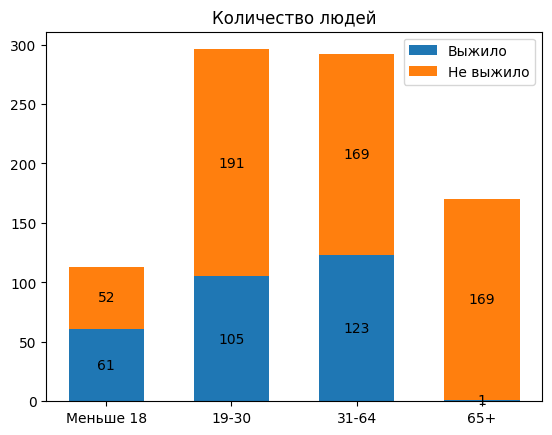

In [21]:

under_18_survived = len(train_df[(train_df.Age < 18) & (train_df.Survived == 1.0)])
under_18_not_survived = len(train_df[(train_df.Age < 18) & (train_df.Survived == 0)])

from_18_to_30_survived = len(train_df[((train_df.Age >= 18) & (train_df.Age <= 30)) & (train_df.Survived == 1)])
from_18_to_30_not_survived = len(train_df[((train_df.Age >= 18) & (train_df.Age <= 30)) & (train_df.Survived == 0)])

from_31_to_64_survived = len(train_df[((train_df.Age >= 31) & (train_df.Age <= 64)) & (train_df.Survived == 1)])
from_31_to_64_not_survived = len(train_df[((train_df.Age >= 31) & (train_df.Age <= 64)) & (train_df.Survived == 0)])

over_65_survived = len(train_df[(train_df.Age > 64) & (train_df.Survived == 1.0)])
over_65_not_survived = len(train_df[(train_df.Age > 64) & (train_df.Survived == 0)])


name = ('Меньше 18', '19-30', '31-64', '65+')
labels = {
    'Выжило': np.array([under_18_survived, from_18_to_30_survived, from_31_to_64_survived, over_65_survived]),
    'Не выжило': np.array([under_18_not_survived, from_18_to_30_not_survived, from_31_to_64_not_survived, from_31_to_64_not_survived]),
}
width = 0.6 


fig, ax = plt.subplots()
bottom = np.zeros(4)

for label, amount in labels.items():
    p = ax.bar(name, amount, width, label=label, bottom=bottom)
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.set_title('Количество людей')
ax.legend()

plt.show()

**Вывод**: Можем заметить, что из возрастной группы 65+ выжил только один. А вот в группе "меньше 18" выжило более половины. Можно сделать вывод, что возраст играет одну из важнейших ролей в выживании. Это можно использовать при дальнейшем обучении модели.

**3. Теперь посмотрим зависимость класса билета и выживаемости.**

([<matplotlib.patches.Wedge at 0x7a16f3ff6110>,
 [Text(0.5056813863013835, 0.976875803543271, '3 класс'),
  Text(-1.0866148078690505, 0.17107968704585155, '2 класс'),
  Text(0.34759762104495984, -1.0436359009941565, '1 класс')])

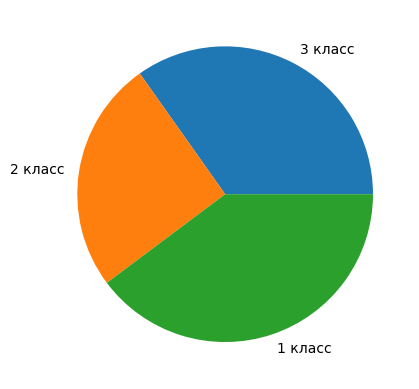

In [22]:
class_3_survived = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 1)])
class_2_survived = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 1)])
class_1_survived = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 1)])

labels = ["3 класс", "2 класс", "1 класс"]
nums = [class_3_survived, class_2_survived, class_1_survived]

fig, ax = plt.subplots()
ax.pie(nums, labels=labels)

**Вывод**: Можно заметить, что 1 и 3 классы примерно равны и больше, чем 2 класс. То есть можно предположить, что люди, купившие билет класса 1 или 3 выживают чаще, чем те, кто купил 2 класс. Чуть позже, как разделим колонку Cabin, проверим эту гипотезу.

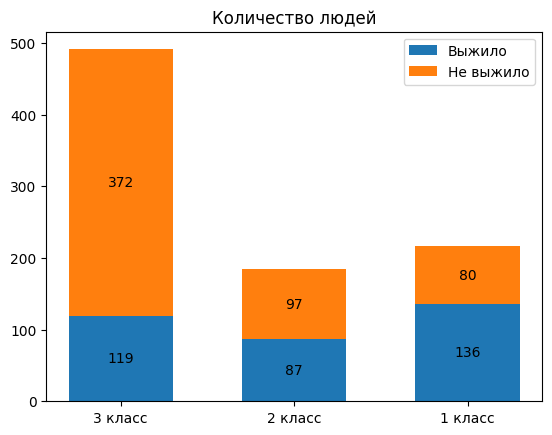

In [23]:
class_3_survived = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 1)])
class_2_survived = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 1)])
class_1_survived = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 1)])
class_3_not_survived = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 0)])
class_2_not_survived = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 0)])
class_1_not_survived = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 0)])

name = ('3 класс', '2 класс', '1 класс')
labels = {
    'Выжило': np.array([class_3_survived, class_2_survived, class_1_survived]),
    'Не выжило': np.array([class_3_not_survived, class_2_not_survived, class_1_not_survived]),
}
width = 0.6 


fig, ax = plt.subplots()
bottom = np.zeros(3)

for label, amount in labels.items():
    p = ax.bar(name, amount, width, label=label, bottom=bottom)
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.set_title('Количество людей')
ax.legend()

plt.show()

**Вывод**: Теперь становится ясно, что наше предположение оказалось не совсем верным. Те, у кого был 3 класс - выживали гораздо реже(при том больше всего купленных билетов), чем те, кто купил 2 класс или 1, причем люди в первом классе выживали чаще всего

# Конец EDA и Feature Engineering.

У данной задачи есть два датасета - один, на котором модель обучается(train), другой - на котором надо модель проверять и затем сабмитить. Я их объединил, чтобы все последующие преобразования проводить одновременно. Далее я их разделю обратно на два датасета(стоит отметить, что в train датасет - 891 строка)

In [24]:
df = pd.concat([train_df, test_df], ignore_index=True) 

Проверим количество пропущенных значений в датасете, чтобы понять, с чем необходимо поработать

In [25]:
df.isnull().sum()

PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                263
SibSp                0
Parch                0
Ticket               0
Fare                 1
Cabin             1014
Embarked             2
TotalRelatives     418
dtype: int64

Хочу заметить, что я специально объединенный датасет назвал как train_df, потому что изначально я писал код для работы с данными отдельно для каждого датасета. Чтобы не менять код, я просто назвал объединенный датасет так же, как и train.

In [26]:
train_df = df # Поэтому я просто присвою объединенный df в переменную train_df
rows, cols = train_df.shape

Начнем заполнять пропущенные значения со столбца Age. Я решил заполнять пропущенное значение локальным средним - то есть, как только я дошел до ячейки с пропущенным значением, я ищу среднее значение из 10 предыдуших ячеек (то есть, если пропущенное значение, например, в ячейке 11, то среднее ищется между 0 и 10 ячейками). Так заполняем все NaN.

In [27]:
import warnings
warnings.simplefilter("ignore")

prev_idx = 0
for i in range(10, rows, 10):
    local_mean = train_df['Age'].iloc[prev_idx:i].describe()['mean']
    train_df['Age'].loc[prev_idx:i] = train_df['Age'].loc[prev_idx:i].fillna(local_mean)
    prev_idx = i
train_df.isnull().sum()

    

PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                  4
SibSp                0
Parch                0
Ticket               0
Fare                 1
Cabin             1014
Embarked             2
TotalRelatives     418
dtype: int64

Теперь напишем функцию, которая будет "доставать" фамилию из столбца Name. Так, мы сможем определять родственников. Если же оставить все как есть, то потом, при использовании LabelEncoder, у нас получатся очень много разных значений, и модель машинного обучения не поймет, кто из них родственники, а кто - нет.

In [28]:
def extract_last_name(full_name):
    return full_name.split()[0][:-1]

train_df['Name'] = train_df['Name'].apply(extract_last_name)

Посмотрим на уникальные значения в столбце Cabin

In [29]:
train_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Отсюда видно, что все каюты начинаются на букву. "Достанем" ее из названия кают

In [30]:
def extract_letter_from_cabin(cabin):
    if isinstance(cabin, str):
        splitted = cabin.split()
        if len(splitted) == 1:
            return splitted[0][0]
        for x in splitted:
            for n in '0123456789':
                if n in x:
                    return x[0]
            
train_df['Cabin'] = train_df['Cabin'].apply(extract_letter_from_cabin)

In [31]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalRelatives
0,1,0.0,3,Braund,male,22.0,1,0,A/5 21171,7.2500,None,S,1.0
1,2,1.0,1,Cumings,female,38.0,1,0,PC 17599,71.2833,C,C,1.0
2,3,1.0,3,Heikkinen,female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,0.0
3,4,1.0,1,Futrelle,female,35.0,1,0,113803,53.1000,C,S,1.0
4,5,0.0,3,Allen,male,35.0,0,0,373450,8.0500,None,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,Spector,male,NaN,0,0,A.5. 3236,8.0500,None,S,NaN
1305,1306,NaN,1,Oliv,female,39.0,0,0,PC 17758,108.9000,C,C,NaN
1306,1307,NaN,3,Saether,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,None,S,NaN
1307,1308,NaN,3,Ware,male,NaN,0,0,359309,8.0500,None,S,NaN


Посмотрим на количество значений в столбце Embarked, это нам потребуется для заполнения пропущенных значений в этом столбце

In [32]:
train_df.Embarked.value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

Отлично, значит больше всего людей отправлялось из S (Southampton). Заполним все пропущенные значения именно этим местом отправки. Также, заполним все пустые ячейки в столбце Cabin на 0 (т.к. здесь нет смысла в том, чтобы заполнять пропущенные значения самой популярной каютой, т.к. будет странно, если, например, кают с буквой А будет очень много, титаник явно столько не вмещает)

In [33]:
train_df['Cabin'] = train_df['Cabin'].fillna('0')

for i in range(rows):
    if type(train_df["Embarked"].iloc[i]) == type(np.nan):
        train_df["Embarked"].loc[i] = "S" # Самое популярное место отправки

In [34]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalRelatives
0,1,0.0,3,Braund,male,22.0,1,0,A/5 21171,7.2500,0,S,1.0
1,2,1.0,1,Cumings,female,38.0,1,0,PC 17599,71.2833,C,C,1.0
2,3,1.0,3,Heikkinen,female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0.0
3,4,1.0,1,Futrelle,female,35.0,1,0,113803,53.1000,C,S,1.0
4,5,0.0,3,Allen,male,35.0,0,0,373450,8.0500,0,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,Spector,male,NaN,0,0,A.5. 3236,8.0500,0,S,NaN
1305,1306,NaN,1,Oliv,female,39.0,0,0,PC 17758,108.9000,C,C,NaN
1306,1307,NaN,3,Saether,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,S,NaN
1307,1308,NaN,3,Ware,male,NaN,0,0,359309,8.0500,0,S,NaN


Проверим, остались ли еще пропущенные значения

In [35]:
train_df.isnull().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age                 4
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin               0
Embarked            0
TotalRelatives    418
dtype: int64

Видим, что есть еще 4 пропущенных значения в столбце Age, а также 1 пропущенное значение в столбце Fare. Их мы заполним просто средними значениями (в случае Age, средним значением из "хвоста" таблицы, а в случае Fare - из всего столбца). Видимо, когда мы проходились алгоритмом, который заполнял пустые значения, какие-то значения были упущены. Вероятно, из конца, так как количество строк не кратно 10 (именно такой шаг был у цикла). Проверим

In [36]:
train_df.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalRelatives
1299,1300,NaN,3,Riordan,female,30.444444,0,0,334915,7.7208,0,Q,NaN
1300,1301,NaN,3,Peacock,female,3.000000,1,1,SOTON/O.Q. 3101315,13.7750,0,S,NaN
1301,1302,NaN,3,Naughton,female,NaN,0,0,365237,7.7500,0,Q,NaN
1302,1303,NaN,1,Minahan,female,37.000000,1,0,19928,90.0000,C,Q,NaN
1303,1304,NaN,3,Henriksson,female,28.000000,0,0,347086,7.7750,0,S,NaN
1304,1305,NaN,3,Spector,male,NaN,0,0,A.5. 3236,8.0500,0,S,NaN
1305,1306,NaN,1,Oliv,female,39.000000,0,0,PC 17758,108.9000,C,C,NaN
1306,1307,NaN,3,Saether,male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,0,S,NaN
1307,1308,NaN,3,Ware,male,NaN,0,0,359309,8.0500,0,S,NaN
1308,1309,NaN,3,Peter,male,NaN,1,1,2668,22.3583,0,C,NaN


Ну да, действительно, так и есть. Все NaN в столбце Age находятся в конце. В общем, заполняем их так, как я описал выше.

In [37]:
mean_age = train_df.tail()['Age'].mean()
train_df['Age'] = train_df['Age'].fillna(mean_age)

train_df['Fare'] = train_df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))


# Этот код я использовал, когда объединил датасет трейна с тестом, в тестовом датасете есть пропущенные значения в столбце Age.

Проверим, что все готово

In [38]:
train_df.isnull().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            0
TotalRelatives    418
dtype: int64

Отлично, больше NaN значений нет (То, что в колонке survived нет 418 значений - это как раз то, что мы будем предсказывать. Эти пропущенные значения как раз из test.csv, который идет вместе с трейн сетом).

Теперь, на основе того, что мы делали выше ("доставали" фамилии и буквы у кают), сделаем соответствующие списки с уникальными фамилиями/буквами.

In [39]:
unique_cabins = list(train_df['Cabin'].unique())

In [40]:
unique_names = list(train_df['Name'].unique())

Наконец, можем использовать LabelEncoder и OneHotEncoder, чтобы преобразовать данные из категориальных в числовые.

Чтобы не увеличивать количество колонок, колонку Name я преобразую с помощью LabelEncoder, так как там довольно много разных фамилий. А колонки Sex, Embarked, Cabin с помощью OneHotEncoder (т.к. данных мало, следовательно добавиться не очень много колонок).

In [41]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

result = OneHotEncoder().fit_transform(train_df['Sex'].values.reshape(-1, 1)).toarray()

train_df[['Female', 'Male']] = pd.DataFrame(result, index = train_df.index)

result = OneHotEncoder().fit_transform(train_df['Embarked'].values.reshape(-1, 1)).toarray()

train_df[['Cherbourg', 'Queenstown', 'Southampton']] = pd.DataFrame(result, index = train_df.index)

result = OneHotEncoder().fit_transform(train_df['Cabin'].values.reshape(-1, 1)).toarray()

train_df[unique_cabins] = pd.DataFrame(result, index = train_df.index)

LE = LabelEncoder()
LE.fit(unique_names)
train_df['Name'] = LE.fit_transform(train_df['Name'])
train_df = train_df.drop(['Sex', 'Embarked', 'Ticket', 'Cabin'], axis=1)

Посмотрим на то, как теперь выглядит наш датасет.

In [42]:
train_df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,...,Southampton,0,C,E,G,D,A,B,F,T
0,1,0.0,3,100,22.00,1,0,7.2500,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,1,182,38.00,1,0,71.2833,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,3,329,26.00,0,0,7.9250,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,1,267,35.00,1,0,53.1000,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,3,15,35.00,0,0,8.0500,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,753,38.75,0,0,8.0500,NaN,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,1306,NaN,1,593,39.00,0,0,108.9000,NaN,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1306,1307,NaN,3,699,38.50,0,0,7.2500,NaN,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,1308,NaN,3,823,38.75,0,0,8.0500,NaN,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**4. Еще хочется проверить, зависит ли как-то буква каюты (A, B, C...) и то, выжил или нет человек**

Для этого, сделаем тот же график, как и в случае, где мы смотрели распределение выживших по каютам. Сейчас отобразим не только выживших, но и погибших. Это мы проверяем гипотезу про то, зависит ли, чаще ли выживает человек в зависимости от того, в какой каюте он был.

([<matplotlib.patches.Wedge at 0x7a16e41cb970>,
 [Text(1.0858588526903141, 0.17581396996278398, 'C'),
  Text(0.4756481739950597, 0.9918461647731294, 'E'),
  Text(-1.0076171015068751, 0.4412570415878751, 'G'),
  Text(-0.6280611262028061, -0.9030721021894449, 'D'),
  Text(0.5644984509916647, -0.9441088384439641, 'A'),
  Text(1.051483484946827, -0.3230827771393518, 'B'),
  Text(1.095375790447749, -0.1007565268405433, 'F'),
  Text(1.0997107953611804, -0.025222342596991246, 'T')])

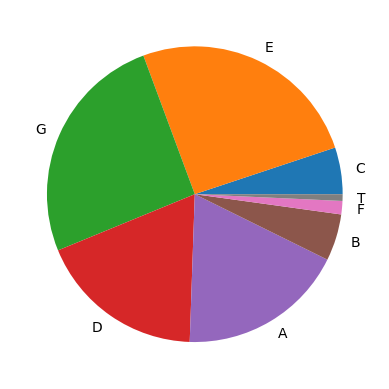

In [43]:
C = len(train_df[(train_df.C == 1) & (train_df.Survived == 1)])
E = len(train_df[(train_df.E == 1) & (train_df.Survived == 1)])
G = len(train_df[(train_df.G == 1) & (train_df.Survived == 1)])
D = len(train_df[(train_df.D == 1) & (train_df.Survived == 1)])
A = len(train_df[(train_df.A == 1) & (train_df.Survived == 1)])
B = len(train_df[(train_df.B == 1) & (train_df.Survived == 1)])
F = len(train_df[(train_df.F == 1) & (train_df.Survived == 1)])
T = len(train_df[(train_df['T'] == 1) & (train_df.Survived == 0)])
labels = unique_cabins[1:]
nums = [C, E, G, D, A, B, F, T]
fig, ax = plt.subplots()
ax.pie(nums, labels=labels)

**Вывод**: Таким образом, люди из кают G и E выживали чаще. Проанализируем подробнее этот признак.

Рассмотрим те каюты, в которых выжило большее количество человек: A, D, G, E. Найдем общее отношение выживших ко всему количеству людей.

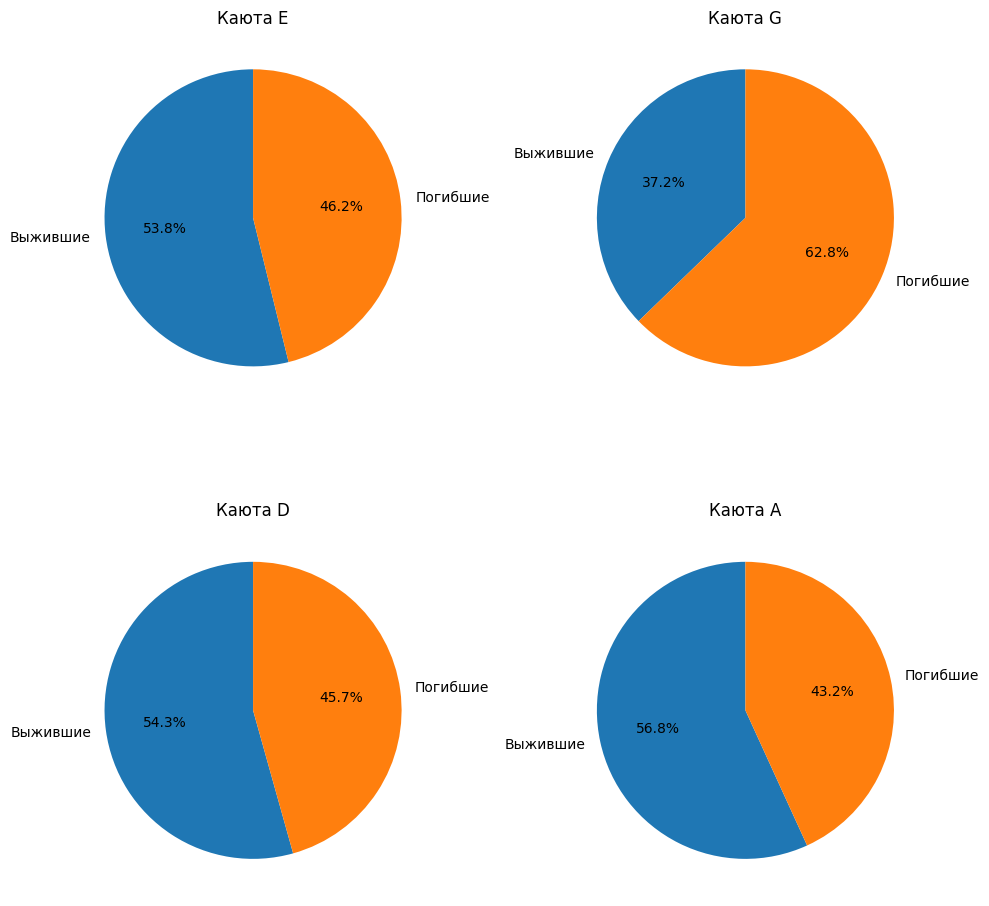

In [44]:
E_1 = len(train_df[(train_df.E == 1) & (train_df.Survived == 1)])
G_1 = len(train_df[(train_df.G == 1) & (train_df.Survived == 1)])
D_1 = len(train_df[(train_df.D == 1) & (train_df.Survived == 1)])
A_1 = len(train_df[(train_df.A == 1) & (train_df.Survived == 1)])

E_overall = len(train_df[(train_df.E == 1)])
G_overall = len(train_df[(train_df.G == 1)])
D_overall = len(train_df[(train_df.D == 1)])
A_overall = len(train_df[(train_df.A == 1)])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].pie([E_1, E_overall - E_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("Каюта E")

axes[0, 1].pie([G_1, G_overall - G_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Каюта G")

axes[1, 0].pie([D_1, D_overall - D_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("Каюта D")

axes[1, 1].pie([A_1, A_overall - A_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Каюта A")

plt.tight_layout()
plt.show()

**Вывод**: Как можем заметить, Чаще всего выживали люди из кают A, D, E по отношению к G. Возможно, это связано с тем, что эти каюты были ближе к выходу (т.к. буквы находятся в начале алфавита, возможно, именно так и называли каюты, чем ближе - тем раньше буква в алфавите.)

А теперь рассмотрим те, где выжило меньшее количество людей: C, T, F, B

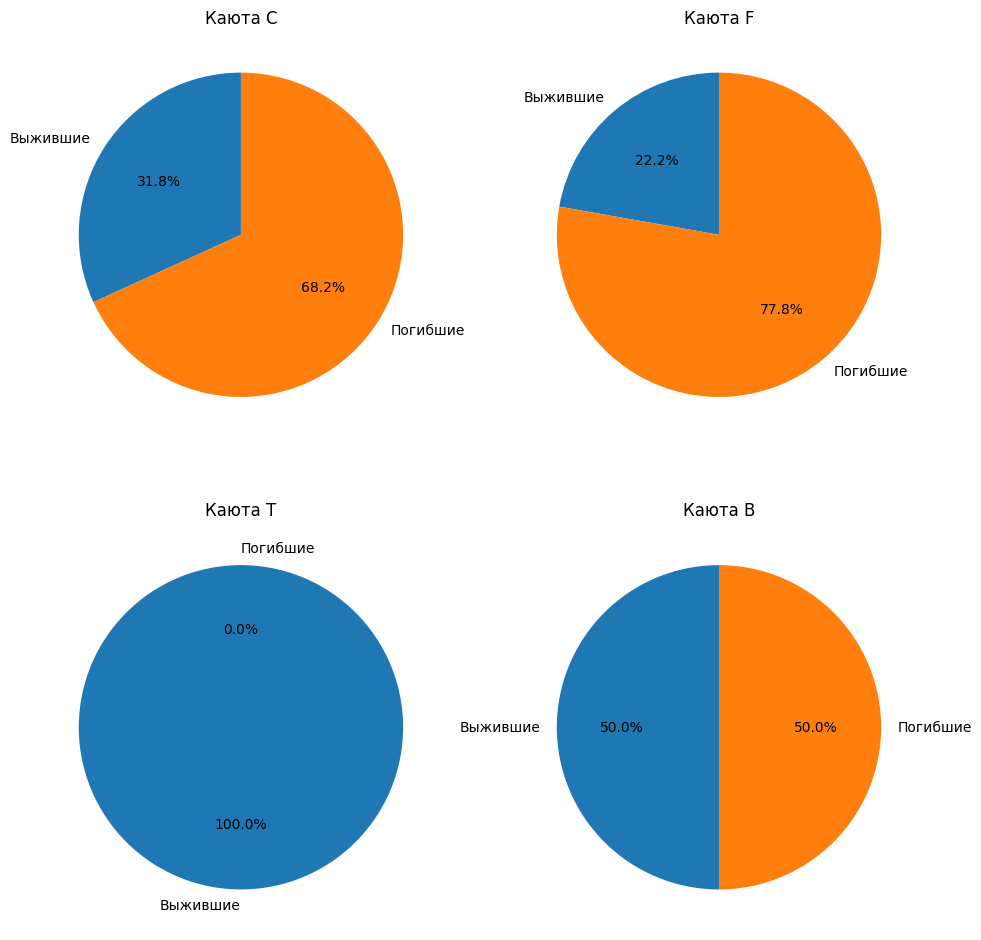

In [45]:
C_1 = len(train_df[(train_df.C == 1) & (train_df.Survived == 1)])
F_1 = len(train_df[(train_df.F == 1) & (train_df.Survived == 1)])
T_1 = len(train_df[(train_df.T == 1) & (train_df.Survived == 1)])
B_1 = len(train_df[(train_df.B == 1) & (train_df.Survived == 1)])

C_overall = len(train_df[(train_df.C == 1)])
F_overall = len(train_df[(train_df.F == 1)])
T_overall = len(train_df[(train_df.T == 1)])
B_overall = len(train_df[(train_df.B== 1)])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].pie([C_1, C_overall - C_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("Каюта C")

axes[0, 1].pie([F_1, F_overall - F_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Каюта F")

axes[1, 0].pie([T_1, T_overall - T_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("Каюта T")

axes[1, 1].pie([B_1, B_overall - B_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Каюта B")

plt.tight_layout()
plt.show()

**Вывод:** Здесь интересная ситуация, если отношение в каюте B удовлетворяет нашей гипотезе о том, что те, кто находились в каютах под буквами, которые находятся в начале алфавита(= каюты рядом с выходом) выживали чаще, то, в каюте C погибших больше, чем выживших. Так что, вероятно, не все так однозначно связано с этим.

Теперь, выделим колонку с тем, выжил человек или нет. Как я говорил ранее, изначальный train.csv содержал 891 строку. В нем колонка Survived присутствует. Следовательно, делаем срез до 891 строки.
В test.csv (в нашем датасете это все строки с 891 и больше) колонки survived нет. Следовательно, можно заметить, что там NaN (как уже было сказано выше). 

In [46]:
survived_col = train_df["Survived"][:891]

Теперь дропнем колонку survived из датасета. Мы запомнили нужную часть, а оставшиеся значения NaN нам ни к чему.

In [47]:
train_df = train_df.drop(["Survived"], axis=1)

Как я и говорил ранее, я объединенный датасет делю на два - train и test. Хочу заметить, что я специально объединенный датасет назвал как train_df, потому что изначально я писал код для работы с данными отдельно ддля каждого датасета. Чтобы не менять код, я просто назвал объединенный датасет так же, как и train.

In [48]:
test_df = train_df[891:] 
train_df = train_df[:891] 
train_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,...,Southampton,0,C,E,G,D,A,B,F,T
0,1,3,100,22.000000,1,0,7.2500,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,182,38.000000,1,0,71.2833,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,3,329,26.000000,0,0,7.9250,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,267,35.000000,1,0,53.1000,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,3,15,35.000000,0,0,8.0500,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,535,27.000000,0,0,13.0000,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,888,1,294,19.000000,0,0,30.0000,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,889,3,383,27.111111,1,2,23.4500,3.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,890,1,69,26.000000,0,0,30.0000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Дропнем айди пассажира, так как оно нам ни к чему(оно дублирует индексы строк) и затем нормализуем датасет при помощи StandardScaler из библиотеки sklearn.

In [53]:
train_df = train_df.drop(['PassengerId'], axis=1)

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_df)

scaled_df_train = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)

scaler.fit(test_df)

scaled_df_test = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

In [ ]:
# survived_col.to_csv("survived.csv") # Я скачивал датасет, чтобы подобрать параметры при помощи GridSearch уже на своем компьютере, тут почему-то это происходит медленно

# Выбор и обучение модели.

Для начала, посмотрим на корреляцию признаков. Для этого построим HeatMap (с учетом новых признаков).

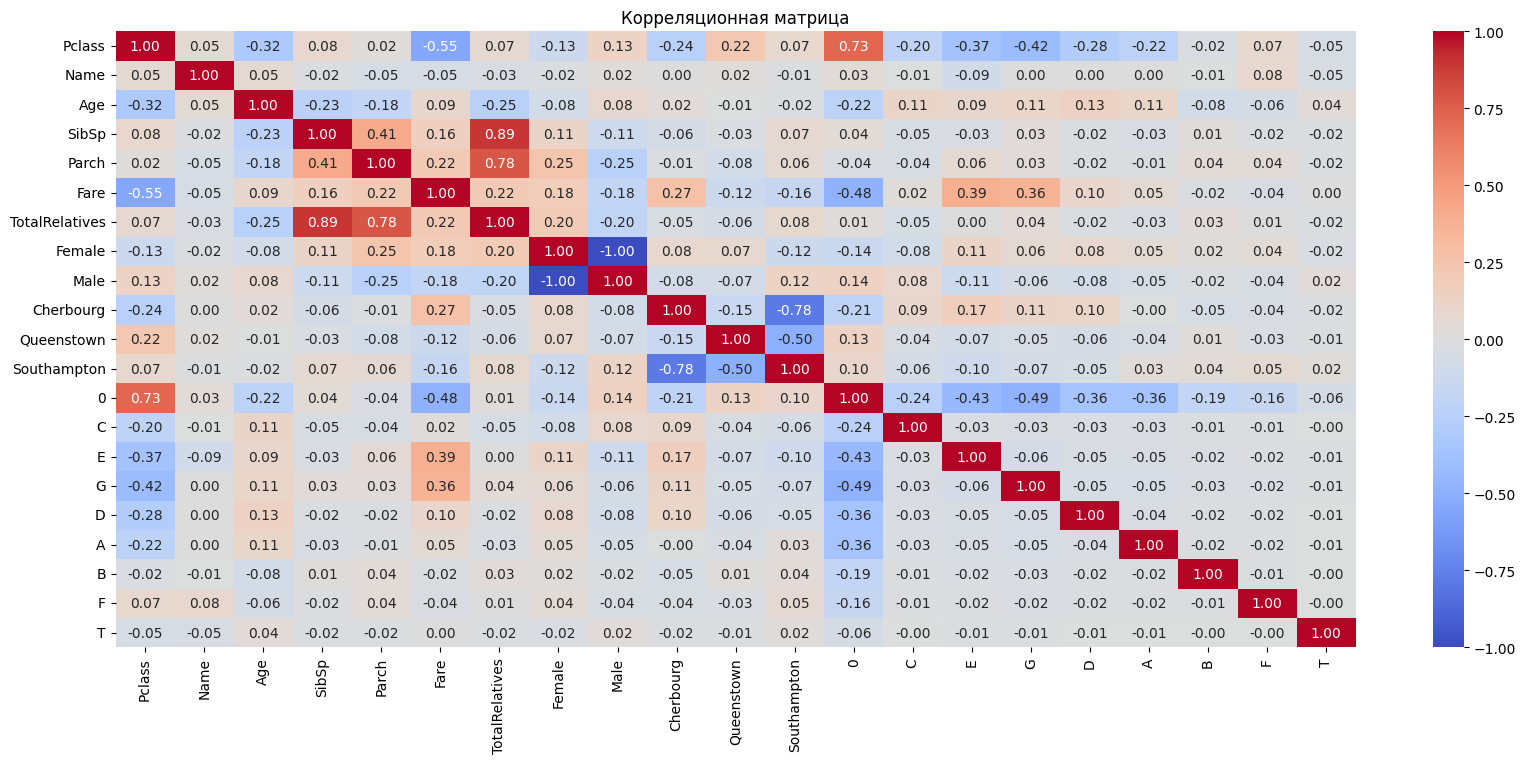

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = train_df.corr()

plt.figure(figsize=(20, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()


**Вывод:** Можем заметить, что новые признаки, которые мы получили из кают (буквы) не очень коррелируют с другими, это значит, что они не такие бесполезные, так как, возможно будут новую информацию модели. Признак totalRelatives, как и ожидалось, коррелирует только с SibSp и Parch. Возможно, стоит дропнуть эти два признака, но я оставлю все как есть. Остальные признаки, которые изначально были в датасете, между собой коррелируют не очень сильно.

Теперь перейдем непосредственно к обучению моделей. Разделем датасет на Х и у - данные для обучения и таргет-переменная соответственно.

In [58]:
from sklearn.model_selection import train_test_split

X = scaled_df_train
y = survived_col


x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True)

Для начала рассмотрим SVM, так как она довольно неплохо показывает себя на датасетах, где мало данных (судя по информации из Интернета и документации).

In [59]:
from sklearn import svm
clf = svm.SVC(kernel='poly', C=20).fit(x_train, y_train)
clf.score(x_test, y_test)

0.7892376681614349

Проведем кросс-валидацию для этой модели. Сначала подберем лучшие параметры с GridSearch, чтобы кросс-валидация проводилась на модели с лучшими параметрами. Хочу заметить, что это кросс-валидация неполноценная (то есть, в выводе только точность, без Confusion Matrix и Classification Report, это будет в конце блокнота для лучшей модели среди всех вариантов).

In [60]:
# Кросс-валидация на svm.SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC

# Определение параметров для GridSearch
param_grid = {
    'C': [4, 5, 6], 
    'degree': [5, 6, 7],   
    'coef0': [1, 1.1, 1.15],
}

clf = SVC(kernel='poly', tol=1e-5) 

grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')

grid_search.fit(X, y)

print(f"Лучшие параметры: {grid_search.best_params_}")

best_clf = grid_search.best_estimator_ 
scores = cross_val_score(best_clf, X, y, cv=10) # Собственно, сама кросс-валидация

print(f"Результаты кросс-валидации: {scores}")
print(f'Средняя точность {scores.mean()}', f'Лучшая точность: {scores.max()}', sep='\n')

Лучшие параметры: {'C': 4, 'coef0': 1, 'degree': 5}
Результаты кросс-валидации: [0.76666667 0.82022472 0.75280899 0.78651685 0.87640449 0.79775281
 0.82022472 0.82022472 0.83146067 0.83146067]
Средняя точность 0.8103745318352059
Лучшая точность: 0.8764044943820225


**Вывод**: Можем заметить, что данная модель показала себя очень даже неплохо. Результаты можно увидеть выше. Явно, один из претендентов на лучшую модель по результатам этой работы.

Попробуем написать модель самостоятельно. Будем использовать и регуляризаторы, и метод EarlyStopping, чтобы избежать переобучения. Сначала создадим модель с большим количеством слоев, и потом будем отталкиваться от результатов.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.02)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(2, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.5740 
Test Accuracy: 0.78


Получаем точность 0.78. Результат доволно неплохой, но можно лучше. Попробуем увеличить количество слоев

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.02)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(2, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7953 - loss: 0.6153 
Test Accuracy: 0.77


Точность не отличается (разница в 0.01 незначительна). Возможно, смысла увеличивать количество слоев нет, так как данных мало. Попробуем уменьшить.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.02)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8103 - loss: 0.5338 
Test Accuracy: 0.79


Так, разница снова незначительна, возможно, повезло. Чтобы проверить это, предлагаю уменьшить количество нейронов в слоях.

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8413 - loss: 0.4560 
Test Accuracy: 0.83


И так, получаем результат 0.83. За все время тестов у меня получалос выбить 0.85. Можно сделать вывод, что нужна модель с более простой архитектурой, как эта, так как данных мало, следовательно, сложной модели тяжелее научится обобщать на таком датасете.

Построим график для лучшей модели, чтобы удостовериться, что нет переобучения.

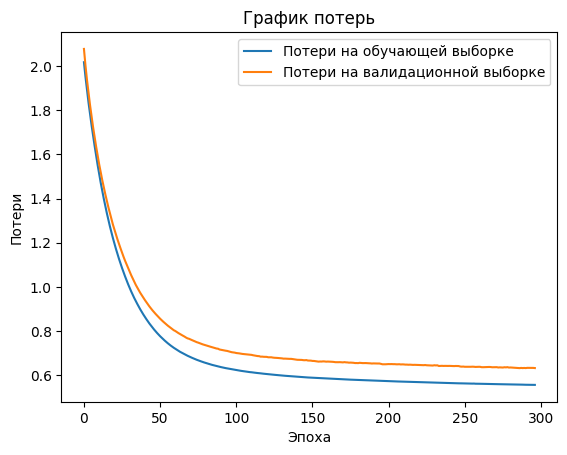

In [234]:
import numpy as np
import matplotlib.pyplot as plt

loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

plt.title("График потерь")
plt.plot(loss, label="Потери на обучающей выборке")
plt.plot(val_loss, label="Потери на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.legend()
plt.show()


Как можно заметить, что потери как на обучающей выборке, так и на валидационной падают, следовательно, переобучения нет, модель неплохо справляется со своей работой.

Вернемся к готовым моделям из sklearn. Попробуем GradientBoostingClassifier

Сначала подберем лучшие параметры для данной модели

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

GBC = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    
}

grid_search = GridSearchCV(estimator=GBC, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)


Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


На основе данной модели также проверим Feature importance с учетом лучших параметров выше. Learning rate по дефолту 0.01

[0.12081078 0.02492792 0.12165742 0.02982679 0.00058662 0.06257936
 0.04232501 0.281005   0.28122188 0.00072097 0.         0.00808891
 0.01405471 0.00307793 0.         0.         0.00246429 0.00619248
 0.         0.00045992 0.        ]


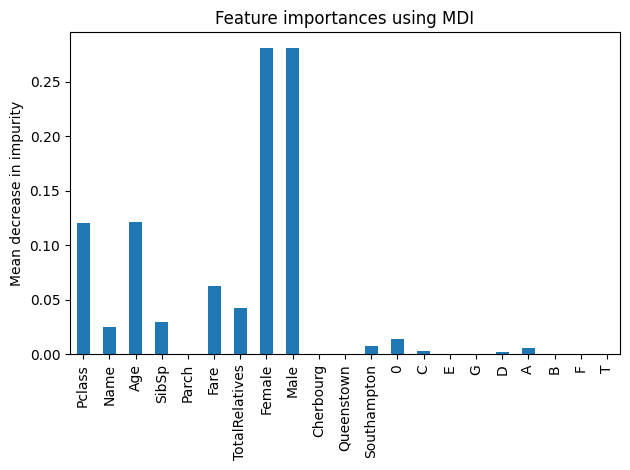

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
GBC = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01,
    max_depth=3, min_samples_leaf=5, min_samples_split=9, 
                                 criterion='squared_error')
GBC.fit(x_train,y_train)
column_names = list(x_train.columns)
feature_names = [column_names[i] for i in range(X.shape[1])]
importances = GBC.feature_importances_
print(importances)
gbc_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
gbc_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


**Вывод**: Заметим, что пол человека оказывает самое сильное влияние на обучение модели, в то время как наши признаки почти никакого влияния (кроме TotalRelatives). Поэтому обучим эту модель сначала на датасете с каютами, а потом без. Проверим их точности.

In [63]:
scaled_df_train_2 = scaled_df_train.drop(['C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], axis=1) # Создадим датасет без колонок с каютами

In [66]:
GBC.fit(x_train, y_train) # С каютами

predictions = GBC.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.7937219730941704


In [68]:
X = scaled_df_train_2
y = survived_col


x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X, y, shuffle=True)

In [69]:
GBC.fit(x_train_2, y_train_2) # Без кают

predictions = GBC.predict(x_test_2)

accuracy = accuracy_score(y_test_2, predictions)
print(accuracy)

0.8161434977578476


**Вывод:** И так, как можем заметить, модель показывает лучшую точность при обучении на датасете без кают. Хотя, разница все равно не очень большая, тем более, модели, которые я написал (или которую я использовал, как SVC) показали результат лучше и с датасетом с каютами. Так что, скинем это все на то, что просто так совпало.

Наконец, рассмотрим еще одну модель **xgb** также на датасете с каютами и без.

In [239]:
import xgboost as xgb
# С каютами

clf = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', 
                       alpha=1, reg_lambda=1, tree_method='approx')

clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.8295964125560538


In [238]:
clf = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', 
                       alpha=1, reg_lambda=1, tree_method='approx')
# Без кают
clf.fit(x_train_2, y_train_2)

predictions = clf.predict(x_test_2)

accuracy = accuracy_score(y_test_2, predictions)
print(accuracy)

0.7847533632286996


**Вывод:** Здесь результат снова интереснее. Хоть данной модели не удалось обогнать SVM.SVC, это не самое интересное, главное, что на датасете без кают она показала результат хуже, чем с каютами. Это еще раз подтверждает мои слова, сказанные выше при обучении модели GBC.

**Общий вывод:** Как можем заметить, лучший результат среди всех моделей показала модель SVM. Стоит отметить, что Support Vector Machine отлично подходит для обучения на небольшом объеме данных, но необходимо сделать предобработку (как в моем случае, при помощи StandardScaler), чтобы не было выбросов (так как SVM неустойчива к ним.)

Теперь сделаем кросс-валидацию на лучшей модели - SVM. С Classification Report и Confusion Matrix

In [66]:

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

clf = SVC(kernel='poly', tol=1e-5, C=4, coef0=1, degree=5)

kf = KFold(n_splits=10)

for fold_number, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    # Вычисление и вывод метрик для текущего фолда
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    print(f"Номер обхода: {fold_number}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)


Номер обхода: 1
Confusion Matrix:
[[43  8]
 [13 26]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80        51
         1.0       0.76      0.67      0.71        39

    accuracy                           0.77        90
   macro avg       0.77      0.75      0.76        90
weighted avg       0.77      0.77      0.76        90

Номер обхода: 2
Confusion Matrix:
[[61  8]
 [ 7 13]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89        69
         1.0       0.62      0.65      0.63        20

    accuracy                           0.83        89
   macro avg       0.76      0.77      0.76        89
weighted avg       0.83      0.83      0.83        89

Номер обхода: 3
Confusion Matrix:
[[46  9]
 [12 22]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81        55
         

Возьмем один обход, например, 5. Рассмотрим его **confusion matrix**: [[48  4] [ 9 28]]. Какой вывод:
**TP:** модель предсказала, что 48 человек выжило, и они действительно выжили;
**FP:** модель предсказала, что 4 человека выжило, но на самом деле они погибли;
**FN:** модель предсказала, что 9 человек погибло, но на самом деле они выжили;
**TN:** модель предсказала, что 28 человек погибло, и они действительно погибли.
Помимо этого, на основе classification report можно сделать вывод, что **recall** (какую долю объектов положительного класса из всех объектов положительного класса)
для класса 0 составляет 92%, а для класса 1 - 76%; **precision** (долю объектов, названных классификатором положительными и при этом действительно являющимися положительными)
для класса 0 - 84%, для класса 1 - 88%. В целом, это весьма неплохой результат, и я уверен, что если продолжить поиск лучших параметров для SVM, а также, возможно, как-то
еще поработать с данными (например, сделать колонку с Mr., Miss., и пр. или убрать ненужные колонки (которые практически никак не влияют на модель)), то можно добиться 
лучших результатов.
Как я уже сказал, **SVM** показала лучший результат. Но что насчет других моделей, которые я использовал? Если посмотреть на модели, которые писались **самостоятельно** 
(при помощи Keras), то я заметил, что чем меньше слоев, тем лучше показывает себя модель (могу сделать вывод, что это связано с тем, что данных мало, а чем больше слоев,
тем сложнее обучить модель, чтобы она научилась обобщать). Если же смотреть на **GradientBoostingClassifier**, то, возможно, он не совсем подходит для нашей задачи. Точно не могу
сказать почему, но данная модель показала себя не очень стабильно (она лишь единожды выбивала метрику в 85%, если же менять набор данных, то метрика сильно падала).
**XGBoost**, возможно, имеет такую же проблему. Поэтому могу сделать вывод, что просто везло в выбором тестового датасета, поэтому получался такой результат.
**SVM** же показал себя лучше всех, показывая неплохие результаты при разном наборе данных (проверил с помощью **cross validation**.)


Нарисуем Confusion Matrix для 5 обхода:

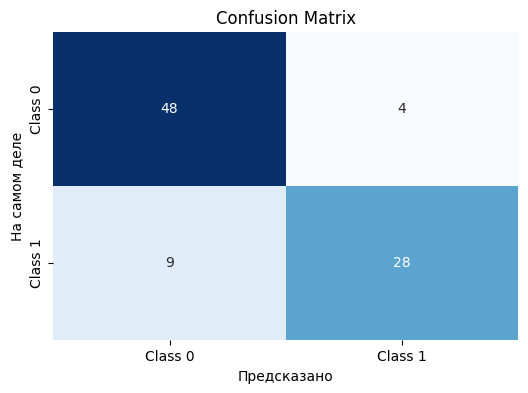

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = np.array([[48, 4], [9, 28]])
labels = ['Class 0', 'Class 1']

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('Предсказано')
ax.set_ylabel('На самом деле')
ax.set_title('Confusion Matrix')
plt.show()